# Problem 1
## 20M10293 Daisuke Kikuta

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#------------#
# Dataset IV #
#------------#

n = 200
x_d4 = 3*(np.random.rand(n, 4) - 0.5)
y_d4 = (2*x_d4[:, 0] - 1*x_d4[:,1] + 0.5 + 0.5*np.random.randn(n)) > 0
y_d4 = 2*y_d4 - 1

# shaping data
y_d4 = y_d4.reshape((200, 1))
x_d4 = np.hstack([x_d4, np.ones((n, 1))])

In [3]:
#------------#
# parameters #
#------------#

hp  = 0.5  # hyper parameter: lambda
itr = 300  # number of iteration

la, v = np.linalg.eigh(np.dot(x_d4.T, x_d4) + 8*hp*np.eye(5))
L = 0.25*np.max(la) # lipschitz constant

## 1. Batch steepest gradient method

In [4]:
w = np.zeros(5).reshape(5, 1)

loss_sgm_history = []
w_sgm_history = []
loss = 0.

for t in range (1, itr + 1):
    exp_t = 1 + np.exp(-y_d4*(np.dot(x_d4, w)))            # dim=(200, 1)
    p = 1/exp_t                                            # dim=(200, 1)

    grad = np.dot(x_d4.T, -y_d4*(1 - p)) + 2*hp*w          # dim=(5, 1)
    loss = np.sum(np.log(exp_t)) + hp*(np.dot(w.T, w) + 1) # dim=(1, 1)
    
    w_sgm_history.append(w)
    loss_sgm_history.append(np.float64(loss))

    w = w - 1/L*grad                                       # dim=(5, 1)

## 2. Newton based method

In [5]:
w = np.zeros(5).reshape(5, 1)

loss_ntn_history = []
w_ntn_history    = []
loss = 0.

for t in range (1, itr + 1):
    exp_t = 1 + np.exp(-y_d4*(np.dot(x_d4, w)))            # dim=(200, 1)
    p = 1/exp_t                                            # dim=(200, 1)

    grad = np.dot(x_d4.T, -y_d4*(1 - p)) + 2*hp*w          # dim=(5, 1)
    hess = np.dot(x_d4.T, p*(1 - p)*x_d4) + 2*hp*np.eye(5) # dim=(5, 5)

    loss = np.sum(np.log(exp_t)) + hp*(np.dot(w.T, w) + 1) # dim=(1, 1)

    w_ntn_history.append(w)
    loss_ntn_history.append(np.float64(loss))

    w = w - np.dot(np.linalg.inv(hess), grad)

## 3. Comparison of the two methods

Text(0, 0.5, '| J(w) - J(w_opt)|')

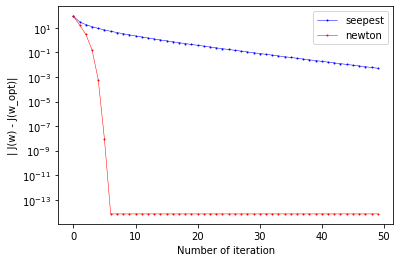

In [6]:
base = min(min(loss_sgm_history), min(loss_ntn_history))

show_itr = 50

plt.plot(np.abs(loss_sgm_history[:show_itr] - base), "bo-", linewidth=0.5, markersize=1, label='seepest')
plt.plot(np.abs(loss_ntn_history[:show_itr] - base), "ro-", linewidth=0.5, markersize=1, label='newton')
plt.legend()
plt.yscale("log")
plt.xlabel("Number of iteration")
plt.ylabel("| J(w) - J(w_opt)|")

## Logistic Regression for multi classification 

## Dataset V

In [7]:
#-----------#
# dataset V #
#-----------#

n = 200
x_d5 = 3 * (np.random.rand(n, 4) - 0.5)
W = np.array([[ 2,  -1, 0.5,],
              [-3,   2,   1,],
              [ 1,   2,   3]])
y_d5 = np.argmax(np.dot(np.hstack([x_d5[:,:2], np.ones((n, 1))]), W.T)
                        + 0.5 * np.random.randn(n, 3), axis=1)

In [8]:
def convert_to_oneshot(n, a):
    return np.identity(n, dtype=np.int)[a]

In [9]:
y_d5 = convert_to_oneshot(3, y_d5)